## Twitter Disaster NLP Competition  

### Introduction  

Over the past decade, Twitter has evolved from a simple short-text messaging service into a powerful platform for real-time communication.  

In the context of emergency management, Twitter serves as a crucial tool for first responders and disaster management teams, enabling swift dissemination of emergency notifications. However, because Twitter is not exclusively used for emergencies, interpreting disaster-related language can be complex. Some users may use words commonly associated with emergencies in non-literal contexts, which adds a layer of ambiguity to message interpretation. For instance, as highlighted in this Natural Language Processing (NLP) challenge, the word *"ablaze"* can signify an actual disaster (e.g., a fire) or be used metaphorically to describe something brilliant or vibrant—such as a tweet describing a twilight sky as *"ablaze."*  

This NLP challenge aligns with this week's Deep Learning topics on Recurrent Neural Networks (RNNs), as we aim to develop a time-series-based approach to analyzing natural language text. In a previous course within this series, unsupervised learning techniques such as Term Frequency-Inverse Document Frequency (TF-IDF) and Non-Negative Matrix Factorization (NMF) were used for multi-class text categorization. However, for this project, we will employ Convolutional Neural Networks (CNNs) to process Twitter text as a sequential left-to-right time-series.  

Unlike traditional tokenization methods that focus on individual words, our approach prioritizes sentence-level semantic understanding. Since TF-IDF is less effective for this purpose, we will instead utilize GloVe (Global Vectors for Word Representation) embeddings alongside standard tokenization. These embeddings capture synonymic relationships through vector representations, which will be fed into our CNN model. In theory, this approach will enable the model to retain contextual memory of previous tokens, allowing for deeper semantic interpretation and better differentiation of words based on their contextual meanings.  It is worth noting that GloVe embeddings are not as highly performing against homographic words.  These are words with the 
same spelling, however, also having different meanings.  This could be useful later in discussion given study outcomes.

In [72]:
import os
print(os.getcwd())
# Change the working directory
os.chdir(os.getcwd())
os.getcwd()

c:\Users\christophermoverton\Week4DL_Project


'c:\\Users\\christophermoverton\\Week4DL_Project'

#### EDA 

For the basic few line inputted, we may immediately notice there are null values in keyword and location.

We may not concern ourselves of this immediately since our focus is in the text column.

In [262]:
import pandas as pd

# Load the dataset
file_path = "train.csv"  # Replace with your actual file path
df = pd.read_csv(file_path)
df_test = pd.read_csv('test.csv')
# Display the first few rows
print(df.head())
print(df_test.head())



   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


Noting there aren't missing 'text' column entries

In [263]:
# Check missing values
print(df.isnull().sum())

# Percentage of missing values
missing_percentage = df.isnull().mean() * 100
print(missing_percentage)


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64


There is a fairly equal distribution between 'Not Disaster' and 'Disaster' tweets. If we feel the classes are 

too imbalanced, we might consider oversampling the 'Disaster' tweets, for example. 

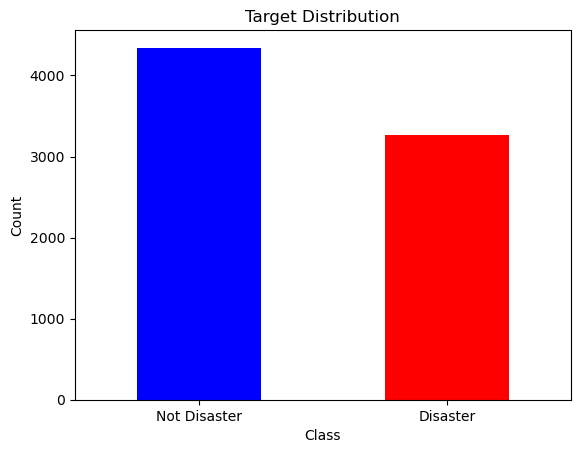

In [75]:
import matplotlib.pyplot as plt

# Count of disaster vs non-disaster tweets
df['target'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.xticks(ticks=[0,1], labels=['Not Disaster', 'Disaster'], rotation=0)
plt.title('Target Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


This gives a good sense of how many tokens we might expect in a tweet.

We can also use this information in setting our padding for a given 

string.  Where the input token vectorized matrix might expect a fixed

dimensional length.

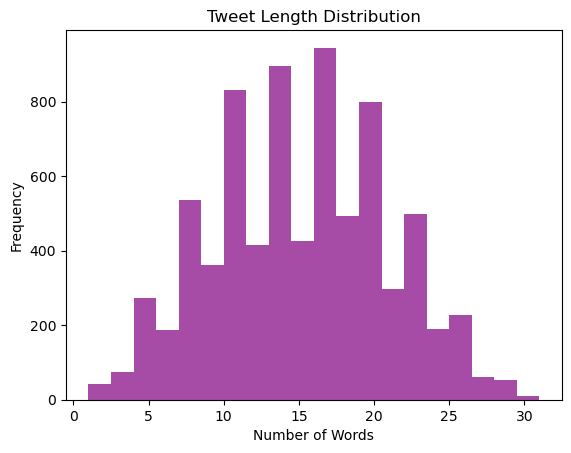

In [76]:
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))

# Histogram of tweet lengths
plt.hist(df['text_length'], bins=20, color='purple', alpha=0.7)
plt.title("Tweet Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


While we won't eliminate 'stop words' as these words for sentence related meaning can 

prove useful, we can examine some of the more common words that aren't stop words to 

see what sorts of disaster words might be occuring.  We might consider within this 

domain of results consider filtering specific words that could be dubious with respect 

to disaster related interpretations, but again this should be carefully considered since 'stop words'

can prove useful for semantic meaning found in sentences.

In [77]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
import re

nltk.download('stopwords')

# Function to clean text and remove stopwords
def clean_text(text):
    text = re.sub(r'\W', ' ', str(text))  # Remove special characters
    text = text.lower()  # Convert to lowercase
    words = text.split()
    words = [word for word in words if word not in stopwords.words('english')]  # Remove stopwords
    return words

# Get most common words
all_words = [word for text in df['text'] for word in clean_text(text)]
word_freq = Counter(all_words)

# Top 20 common words
common_words = word_freq.most_common(20)
print(common_words)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\christophermoverton\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package stopwords is already up-to-date!


[('co', 4740), ('http', 4309), ('https', 411), ('like', 348), ('û_', 348), ('amp', 344), ('fire', 254), ('get', 229), ('new', 226), ('via', 220), ('2', 215), ('people', 200), ('news', 197), ('one', 196), ('video', 165), ('disaster', 158), ('emergency', 158), ('police', 143), ('would', 137), ('u', 135)]


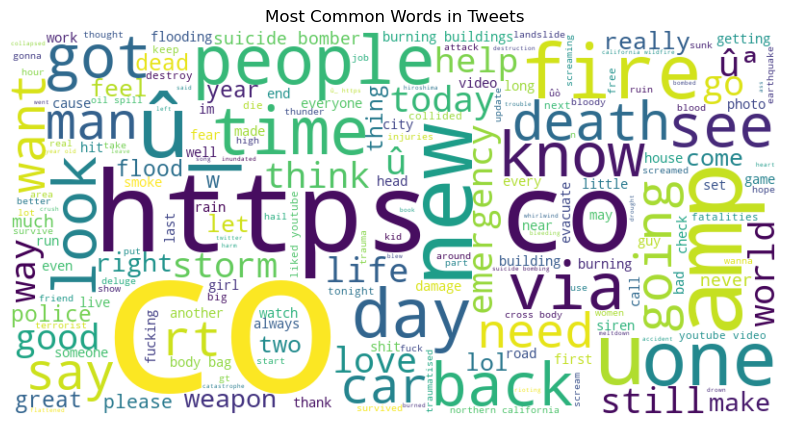

In [78]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(all_words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Tweets")
plt.show()


As we might expect, we see a number of disaster keywords for this dataset.

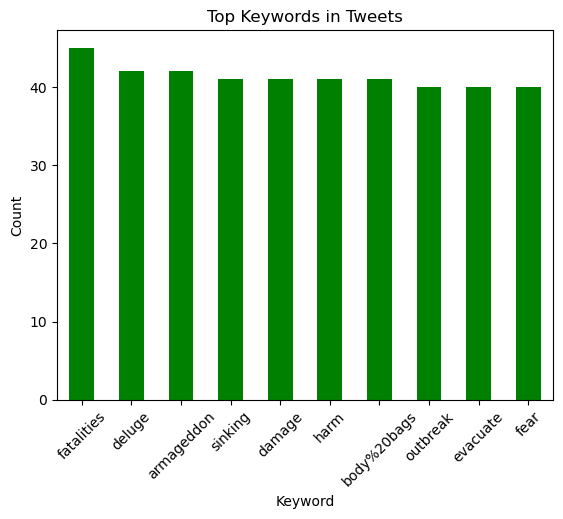

In [79]:
df['keyword'].value_counts().head(10).plot(kind='bar', color='green')
plt.title("Top Keywords in Tweets")
plt.xlabel("Keyword")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


Location data tells us where the predominance of disaster related twitter

exists.  Because this competition is language specific, we'd notice the 

location biases.

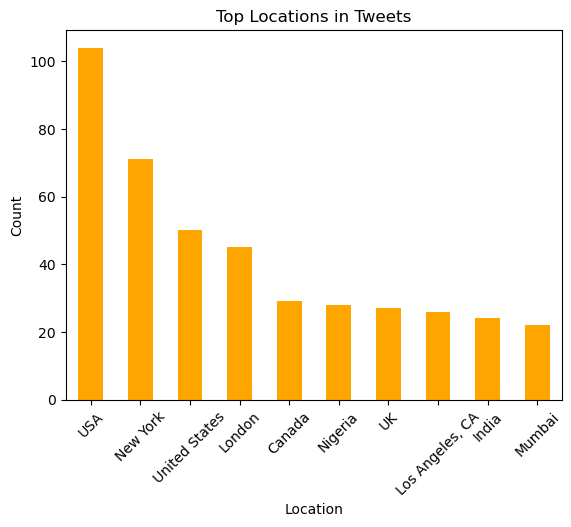

In [11]:
df['location'].value_counts().head(10).plot(kind='bar', color='orange')
plt.title("Top Locations in Tweets")
plt.xlabel("Location")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


Let's start by cleaning up our Twitter text. First, we'll convert all text to lowercase to ensure uniformity. 

Next, we'll remove some—but not all—punctuation.  We want to:  normalize,  and remove unwanted noise (reducing vocabulary needs).

Finally, we will apply lemmatization, which reduces words to their root forms. For instance, verbs will be converted 

from different tenses to their base form, reducing variations and simplifying the text. This can help in standardizing 

word representations. However, if we find that lemmatization negatively impacts semantic learning, we can disable it as needed.

In [264]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("wordnet")

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = text.replace('\n', ' ')           # replace the newline character with a space
    text = text.replace('w/', 'with ')        # replace w/ with 'with'
    text = text.replace('&amp', 'and')       # replace &amp with 'and'
    text = text.replace('Ûªm', 'am')
    text = re.sub(r'\S*&gt\S*', ' ', text)   # remove symbol '&gt'
    text = re.sub(r'\S*&lt\S*', ' ', text)   # remove symbol '&lt'
    text = re.sub(r'[^\x00-\x7F]', ' ', text)  # remove non-ASCII letters
    text = re.sub(r'https?\S+', ' ', text)  # remove urls
    text = re.sub(r'@\S+', ' ', text)     # remove mentions
    text = re.sub(r'#\S+', '', text) # remove hashtags
    text = re.sub(r'\s+', ' ', text)  # remove extra space

    # Remove stopwords
    #stop_words = set(stopwords.words('english'))
    #text = ' '.join(word for word in text.split() if word not in stop_words)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())

    return text

df['clean_text'] = df['text'].apply(clean_text)
df_test['clean_text'] = df_test['text'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\christophermoverton\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\christophermoverton\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package wordnet is already up-to-date!


The next line is not required if you have the necessary glove...txt file 

In [16]:
wget http://nlp.stanford.edu/data/glove.6B.zip
unzip glove.6B.zip


SyntaxError: invalid syntax (3057609168.py, line 1)

This preprocessing pipeline prepares textual data for input into a deep learning model:
1. **Splits data** into training and testing sets.
2. **Tokenizes text**, converting words into numerical representations.
3. **Pads sequences** to a uniform length, ensuring compatibility with neural network models.

This structured approach allows for efficient processing of textual data for natural language processing (NLP) tasks.

In [267]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# 1. Splitting the data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['clean_text'], df['target'], test_size=0.2, random_state=42
)

# 2. Tokenization & Padding
vocab_size = 20000  # Adjust vocabulary size
max_len = 50  # Max sequence length
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['clean_text'])

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad sequences to ensure uniform length
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

Let’s go ahead and load pre-trained GloVe (Global Vectors for Word Representation) embeddings and create an embedding matrix for use in a deep learning model.


Why are we using GloVe embeddings here?


These embeddings enhance our GRU layer by providing semantic meaning to each token. Each word is replaced by a fixed-size vector (e.g., 100-dimensional), so a 

sentence with five words would be converted into a matrix of shape 5×100.


How does this help us?


GloVe embeddings are trained on large corpora and capture relationships between words — such as synonyms or related terms — by analyzing word co-occurrence 

statistics. This means that each word vector carries more than just its identity; it includes context and associations with similar words.

By incorporating GloVe embeddings, our model gains a richer understanding of language. Rather than treating each token as an isolated unit, the GRU (or LSTM)

layers receive vectors that reflect the word's meaning and relationships, allowing the model to better interpret the sentiment or intent behind each tweet.

#### **Embedding matrix**:

- Uses **100-dimensional** word embeddings (`embedding_dim = 100`).
- Limits the vocabulary to **20,000 words** (`vocab_size = 20000`).

In [268]:
# Load GloVe embeddings
embedding_dim = 100  # Choose 100D embeddings
embedding_index = {}
glove_path = "glove.6B.100d.txt"  # Ensure the file is in your working directory
with open(glove_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = coefs

# Create Embedding Matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
word_index = tokenizer.word_index

for word, i in word_index.items():
    if i < vocab_size and word in embedding_index:
        embedding_matrix[i] = embedding_index[word]

print("Embedding matrix shape:", embedding_matrix.shape)

Embedding matrix shape: (20000, 100)


### **Model Description and Summary: BiGRU Model with GloVe Embeddings for Binary Classification**  

 **Bidirectional Gated Recurrent Unit (BiGRU) model** uses 

**pre-trained GloVe embeddings** for **binary classification** of text data (e.g., disaster 

vs. non-disaster tweets). It includes data preprocessing, model compilation, training with 

callbacks, evaluation, and threshold optimization for F1-score.

##### **BiGRU model**:

- Uses **pre-trained GloVe embeddings** (`Embedding` layer) as input.
- **BiGRU layers** (Bidirectional GRU):
  - **First BiGRU (128 units)** with `return_sequences=True` to allow stacked layers.
  - **Second BiGRU (64 units)** for deeper context understanding.
- **Dense Layer (32 units)** with **ReLU activation** and **L2 regularization (0.01)** to reduce overfitting.
- **Dropout layers (0.5 probability)** help prevent overfitting.
- **Output layer** with a **sigmoid activation** for binary classification.

Why Bidirectional modeling?  As it turns out in LSTM or CNN models in general for NLP classification

tasks reading input sentences sequentially from left-to-right and right-to-left, provides additional 

benefit relative a strict left-to-right sequential reading of a sentence sequence which is most common

for a latin based semantic language using LSTM, for example.   

What does 128 units versus 64 units actually mean in context of GRU here for the first BiGRU layer?

128 units means more memory versus 64 units which is less memory.  You might think that setting this

to a higher parameter setting is beneficial, but the answer isn't so clear.  For example, you can

have too much memory which works well in rapidly fitting training data, but this leads also to a rapid

convergence and subsequent overfit on validation data.  While these initial parameters may seem like 

a great start, we will additionally find out differences via hyper-parameter tuning later.

##### **Model Compiliation**:  

- **Adam optimizer** with a small learning rate (`0.0005`) for stable convergence.
- **Binary cross-entropy loss function**, suitable for binary classification.
- **Accuracy metric** to track performance.

##### **Training Callbacks**:

- **EarlyStopping**: Stops training if validation loss does not improve for 3 consecutive epochs.
- **ReduceLROnPlateau**: Reduces learning rate if validation loss stagnates for 2 epochs.

##### **Model Training**:

- **15 epochs** with a **batch size of 32**.
- Uses **training and validation data**.
- **Callbacks** optimize training by adjusting learning rate and early stopping.

##### **Saving the Trained Model**:

- Saves the trained model for later use.

##### **Evaluating the Model**:  

- Computes **final test accuracy** on the unseen test set.

##### **Optimizing the Classification Threshold for F1-Score**:

- **Calculates predictions as probabilities** from the model.
- **Tries different classification thresholds (0.1 to 0.9, step=0.05)** to find the **best F1-score**.
- The **threshold that maximizes F1-score** is selected.

Why F1 optimization?  The Kaggle Competition score is awarded on the basis of F1 results

##### **Final Predictions**:
- **Applies the best threshold** for classification.
- **Prints a classification report** with precision, recall, and F1-score.

In [269]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



# Convert labels to numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Define BiGRU Model with GloVe
model = keras.Sequential([
    keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                           weights=[embedding_matrix], input_length=max_len, trainable=False),
    keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True)),  # Replaced LSTM with GRU
    keras.layers.Dropout(0.5),  # Prevents overfitting
    keras.layers.Bidirectional(keras.layers.GRU(64)),  # Second GRU layer
    keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # L2 Regularization
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')  # Binary Classification
])

# Compile the Model
optimizer = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
# Compile the model
#model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

print(model.summary())  # Display model architecture
#model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
#model.summary()

# Callbacks for Better Training
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=0.00001)
# 4. Compile and Train the Model
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the Model
history = model.fit(train_padded, train_labels, 
                    epochs=15, batch_size=32, 
                    validation_data=(test_padded, test_labels), 
                    callbacks=[early_stopping, reduce_lr])

# Save the Model
model.save("bigru_glove_model.h5")

# 9️⃣ Evaluate the Model
loss, accuracy = model.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# 1️⃣0️⃣ Find the Best Threshold for F1-Score
probabilities = model.predict(test_padded)

best_f1 = 0
best_threshold = 0.5
thresholds = np.arange(0.1, 0.9, 0.05)  # Try different threshold values

for t in thresholds:
    preds = (probabilities > t).astype("int32")
    f1 = f1_score(test_labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Best Threshold: {best_threshold}, Best F1-Score: {best_f1:.4f}")

# 1️⃣1️⃣ Use the Best Threshold for Final Predictions
final_predictions = (probabilities > best_threshold).astype("int32")

# Print Final Classification Report
print(classification_report(test_labels, final_predictions))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 100)           2000000   
                                                                 
 bidirectional_14 (Bidirecti  (None, 50, 256)          176640    
 onal)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 50, 256)           0         
                                                                 
 bidirectional_15 (Bidirecti  (None, 128)              123648    
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 32)                4128      
                                                                 
 dropout_17 (Dropout)        (None, 32)               

 ### **Advanced BiGRU Model with Attention and GloVe Embeddings**

Here is a more advanced BigGRU model with Attenion layer and the same GloVe Embeddings layer.

Here are the following updates:

##### **First BiGRU Layer (512 Units)**
- **Bidirectional GRU (512 units)**: Captures both **forward and backward** dependencies in text.
- **Layer Normalization**: Stabilizes learning.
- **Dropout (30%)**: Reduces overfitting.

#####  **Second BiGRU Layer (256 Units)**
- Another **BiGRU layer** (256 units) for **deeper feature extraction**.
- Maintains `return_sequences=True` for further sequential processing.

##### **Attention Layer (Focus on Important Words)**
- **Attention mechanism**: Helps focus on key words while filtering noise.
- **Residual connection**: Preserves contextual information while refining feature maps.

##### **Third BiGRU Layer (128 Units)**
- **Final BiGRU layer** (128 units) **without return sequences** to prepare for dense layers.

##### **Fully Connected Layer (Dense)**
- **Dense Layer (128 units, Swish activation)**: Swish improves gradient flow over ReLU.
- **L2 Regularization (0.001)**: Reduces model complexity and overfitting.

##### **Output Layer (Binary Classification)**
- Uses a **sigmoid activation** function for **binary classification**.

Note:  
- we have increased the number of units on the first BigGRU layer from 128 to 512 units.
- we have increased the number of units on the second BigGRU layer from 64 to 256 units.
- we have added a third BigGru layer with 128 units.
- we have increased the number of dense units from 32 to 128 units.
- we have added an activation layer for attention mechanism for additional keyword support.

In [270]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dropout, Dense, LayerNormalization, Attention, Add, Flatten

# Define Input Layer
inputs = keras.layers.Input(shape=(max_len,), name="input_layer")

# 📌 Embedding Layer (GloVe) - Non-trainable
x = Embedding(input_dim=vocab_size,  
              output_dim=embedding_dim,  
              weights=[embedding_matrix],  
              input_length=max_len,  
              trainable=False,  
              name="embedding_layer")(inputs)

# 📌 First BiGRU Layer (512 units)
x = Bidirectional(GRU(512, return_sequences=True, activation="tanh", recurrent_activation="sigmoid"))(x)
x = LayerNormalization()(x)
x = Dropout(0.3)(x)

# 📌 Second BiGRU Layer (256 units)
x = Bidirectional(GRU(256, return_sequences=True, activation="tanh", recurrent_activation="sigmoid"))(x)
x = LayerNormalization()(x)
x = Dropout(0.3)(x)

# 📌 Attention Layer (Focus on Important Words)
attention = Attention(name="attention_layer")([x, x])
x = Add()([x, attention])  # Residual Connection with Attention

# 📌 Third BiGRU Layer (128 units, Set `return_sequences=False` for dense layer compatibility)
x = Bidirectional(GRU(128, return_sequences=False, activation="tanh", recurrent_activation="sigmoid"))(x)
x = LayerNormalization()(x)
x = Dropout(0.3)(x)

# 📌 No Need for GlobalAveragePooling1D() Since Output is Already 2D
# 📌 Fully Connected Dense Layer
x = Dense(128, activation='swish', kernel_regularizer=l2(0.001), name="dense_1")(x)  
x = Dropout(0.3, name="dropout_3")(x)

# 📌 Output Layer (Binary Classification)
outputs = Dense(1, activation='sigmoid', name="output_layer")(x)

# Build Model
model = keras.Model(inputs, outputs, name="Stable_BiGRU_Model")

# Compile the Model with Standard Adam Optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])


# Train the Model
history = model.fit(train_padded, train_labels, 
                    epochs=15, batch_size=32, 
                    validation_data=(test_padded, test_labels), 
                    callbacks=[early_stopping, reduce_lr])

# Save the Model
model.save("bigru_glove_model2.h5")

# 9️⃣ Evaluate the Model
loss, accuracy = model.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# 1️⃣0️⃣ Find the Best Threshold for F1-Score
probabilities = model.predict(test_padded)

best_f1 = 0
best_threshold = 0.5
thresholds = np.arange(0.1, 0.9, 0.05)  # Try different threshold values

for t in thresholds:
    preds = (probabilities > t).astype("int32")
    f1 = f1_score(test_labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Best Threshold: {best_threshold}, Best F1-Score: {best_f1:.4f}")

# 1️⃣1️⃣ Use the Best Threshold for Final Predictions
final_predictions = (probabilities > best_threshold).astype("int32")

# Print Final Classification Report
print(classification_report(test_labels, final_predictions))

Epoch 1/15
191/191 [==============================] - 15s 32ms/step - loss: 0.7690 - accuracy: 0.6959 - val_loss: 0.6515 - val_accuracy: 0.7919 - lr: 1.0000e-04
Epoch 2/15
191/191 [==============================] - 5s 28ms/step - loss: 0.6725 - accuracy: 0.7594 - val_loss: 0.6132 - val_accuracy: 0.8083 - lr: 1.0000e-04
Epoch 3/15
191/191 [==============================] - 5s 27ms/step - loss: 0.6367 - accuracy: 0.7885 - val_loss: 0.6027 - val_accuracy: 0.8070 - lr: 1.0000e-04
Epoch 4/15
191/191 [==============================] - 5s 28ms/step - loss: 0.6220 - accuracy: 0.7860 - val_loss: 0.6216 - val_accuracy: 0.7919 - lr: 1.0000e-04
Epoch 5/15
191/191 [==============================] - 6s 29ms/step - loss: 0.6037 - accuracy: 0.7998 - val_loss: 0.6032 - val_accuracy: 0.8030 - lr: 1.0000e-04
Epoch 6/15
191/191 [==============================] - 6s 30ms/step - loss: 0.5810 - accuracy: 0.8099 - val_loss: 0.5906 - val_accuracy: 0.8129 - lr: 5.0000e-05
Epoch 7/15
191/191 [===================

### **Tunable BiGRU Model with Attention and Hyperparameter Optimization**
Let's turn now to model optimization by creating a tunable BigGRU model.

Essentially we are implementing the same components as in the model before

excepting that this model includes tuning range conditions and step conditions

##### **Key Features of the Model**

 **Uses Pre-trained GloVe Embeddings**  
   - Embedding layer is **non-trainable** to retain semantic integrity.  

 **Stacked BiGRU Layers with Tunable Units & Dropout**  
   - **First BiGRU layer** (64-256 units).  
   - **Second BiGRU layer** (32-128 units).  
   - **Final BiGRU layer** (32-128 units).  
   - Dropout between **0.3 to 0.6** (tunable) to prevent overfitting.  

 **Attention Mechanism**  
   - Enhances **important word selection** by applying an **attention layer** with a **residual connection**.

 **Tunable Fully Connected Layer**  
   - Dense layer with **16-128 units** and **L2 regularization (1e-5 to 1e-2)**.  

 **Tunable Learning Rate for Adam Optimizer**  
   - Search range: **1e-4 to 5e-3** (log scale).  

##### **Summary of the tuning hyper-parameters**:
- GRU units in each layer.
- Dropout rates.
- Dense layer size.
- L2 regularization strength.
- Learning rate.

In [271]:


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dropout, Dense, Attention, Add

# Define the model with tunable hyperparameters and Attention Mechanism
def build_model(hp):
    inputs = keras.layers.Input(shape=(max_len,), name="input_layer")
    
    # 📌 Embedding Layer (GloVe)
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                  weights=[embedding_matrix], input_length=max_len, trainable=False)(inputs)

    # 📌 First BiGRU Layer
    x = Bidirectional(GRU(
        units=hp.Int("gru_units_1", min_value=64, max_value=256, step=64),  
        return_sequences=True))(x)
    x = Dropout(hp.Float("dropout_1", min_value=0.3, max_value=0.6, step=0.1))(x)

    # 📌 Second BiGRU Layer
    x = Bidirectional(GRU(
        units=hp.Int("gru_units_2", min_value=32, max_value=128, step=32), 
        return_sequences=True))(x)
    x = Dropout(hp.Float("dropout_2", min_value=0.3, max_value=0.6, step=0.1))(x)

    # 📌 Attention Layer (Focuses on Important Words)
    attention = Attention(name="attention_layer")([x, x])
    x = Add()([x, attention])  # Residual connection with attention

    # 📌 Final BiGRU Layer (Extract Important Features)
    x = Bidirectional(GRU(
        units=hp.Int("gru_units_3", min_value=32, max_value=128, step=32), 
        return_sequences=False))(x)
    x = Dropout(hp.Float("dropout_3", min_value=0.3, max_value=0.6, step=0.1))(x)

    # 📌 Fully Connected Dense Layer
    x = Dense(hp.Int("dense_units", min_value=16, max_value=128, step=16), 
              activation='relu', kernel_regularizer=l2(hp.Float("l2", 1e-5, 1e-2, sampling="log")))(x)
    x = Dropout(hp.Float("dropout_4", min_value=0.3, max_value=0.6, step=0.1))(x)

    # 📌 Output Layer
    outputs = Dense(1, activation='sigmoid')(x)

    # Build the Model
    model = keras.Model(inputs, outputs)

    # 📌 Compile the Model with a Tunable Learning Rate
    optimizer = keras.optimizers.Adam(
        learning_rate=hp.Float("learning_rate", min_value=1e-4, max_value=5e-3, sampling="log")
    )
    
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    
    return model


### **RandomSearch from Keras Tuner**

- Optimization Objective: val_loss

Minimizes validation loss to improve generalization.

- max_trials for each trial project.  This saves in memory

the trials run alongside hyper-parameter tuning configurations.


In [272]:
import keras_tuner as kt  # Ensure this is included in your imports

# Define the tuner
# Define the tuner
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=15,  # Number of different combinations to try
    executions_per_trial=1,  # Run each model once
    directory="tuner_results",
    project_name="bigru_attention_tuning4"
)



Next we implement the tuner.search() which runs the trials.

We should note we have early stopping and reduced learning callbacks for these 

trial runs staged, otherwise, at 20 epochs per trial.  Once having completed the 

tuner.search() trials, we can retrieve the best hyperparameter model.

In [273]:
# Define Callbacks to Prevent Overfitting
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=0.00001)

# Search for best hyperparameters
tuner.search(train_padded, train_labels,
             epochs=20, batch_size=32,
             validation_data=(test_padded, test_labels),
             callbacks=[early_stopping, reduce_lr])


# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=10)[0]

Trial 15 Complete [00h 00m 32s]
val_loss: 0.4426320791244507

Best val_loss So Far: 0.4312887191772461
Total elapsed time: 00h 11m 48s


Let's build the best model and run training on this to see the "best"

results.

In [274]:
# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(train_padded, train_labels,
                         epochs=15, batch_size=32,
                         validation_data=(test_padded, test_labels),
                         callbacks=[early_stopping, reduce_lr])

# Save the best model
best_model.save("best_bigru_glove_model.h5")

# 9️⃣ Evaluate the Model
loss, accuracy = model.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# 1️⃣0️⃣ Find the Best Threshold for F1-Score
probabilities = model.predict(test_padded)

best_f1 = 0
best_threshold = 0.5
thresholds = np.arange(0.1, 0.9, 0.05)  # Try different threshold values

for t in thresholds:
    preds = (probabilities > t).astype("int32")
    f1 = f1_score(test_labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Best Threshold: {best_threshold}, Best F1-Score: {best_f1:.4f}")

# 1️⃣1️⃣ Use the Best Threshold for Final Predictions
final_predictions = (probabilities > best_threshold).astype("int32")

# Print Final Classification Report
print(classification_report(test_labels, final_predictions))

Epoch 1/15
191/191 [==============================] - 9s 29ms/step - loss: 0.5643 - accuracy: 0.7204 - val_loss: 0.4750 - val_accuracy: 0.7827 - lr: 2.3009e-04
Epoch 2/15
191/191 [==============================] - 5s 24ms/step - loss: 0.4781 - accuracy: 0.7844 - val_loss: 0.4436 - val_accuracy: 0.8096 - lr: 2.3009e-04
Epoch 3/15
191/191 [==============================] - 5s 28ms/step - loss: 0.4631 - accuracy: 0.7964 - val_loss: 0.4401 - val_accuracy: 0.8142 - lr: 2.3009e-04
Epoch 4/15
191/191 [==============================] - 4s 24ms/step - loss: 0.4470 - accuracy: 0.8054 - val_loss: 0.4415 - val_accuracy: 0.8056 - lr: 2.3009e-04
Epoch 5/15
191/191 [==============================] - 4s 24ms/step - loss: 0.4388 - accuracy: 0.8051 - val_loss: 0.4383 - val_accuracy: 0.8201 - lr: 2.3009e-04
Epoch 6/15
191/191 [==============================] - 5s 24ms/step - loss: 0.4300 - accuracy: 0.8130 - val_loss: 0.4377 - val_accuracy: 0.8221 - lr: 2.3009e-04
Epoch 7/15
191/191 [====================

Below are training and validation accuracy results alongside training and validation

losses per epoch of training.

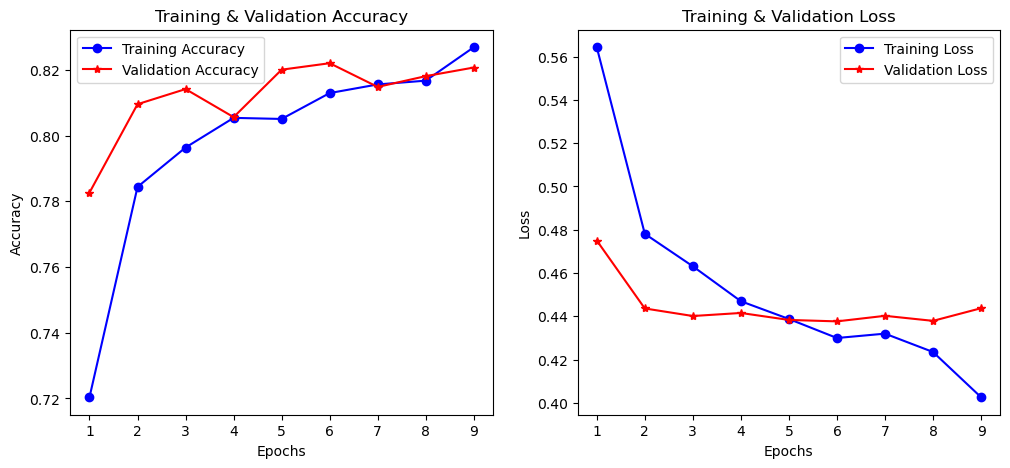

In [275]:
import matplotlib.pyplot as plt

# Function to Plot Training History
def plot_training_history(history):
    """Plots accuracy and loss curves from the model training history."""
    
    # Extract loss and accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)

    # 📌 Plot Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)  # (rows, cols, index)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    # 📌 Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    plt.show()

# Call the function to plot
plot_training_history(history)


Let's go ahead and prepare test.csv data (stored in df_test) for prediction labeling, 

so that we can submit results to Kaggle for scoring.  The cell below tokenize and sequence

the test.csv tweets (from clean_text as applied also to train.csv data), and then pad 

this tweet data from model prediction preparation. 

Cells to 224 to 228 are simply confirming procedure that the tokenizer has converted

into sequences.  Further explanation will be provided in the Results and Discusssion 

sections why I have implemented this as a diagnostic backup.

In [277]:
test_sequences_comp = tokenizer.texts_to_sequences(df_test['clean_text'])

# Pad sequences to ensure uniform length
#train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_padded_comp = pad_sequences(test_sequences_comp, maxlen=max_len, padding='post', truncating='post')

In [278]:
print("Training Tokenizer Vocab Size:", len(tokenizer.word_index))
print("Top 10 Words in Tokenizer:", list(tokenizer.word_index.keys())[:10])


Training Tokenizer Vocab Size: 13512
Top 10 Words in Tokenizer: ['the', 'a', 'in', 'to', 'of', 'and', 'i', 'is', 'for', 'on']


In [279]:
# Print raw test text
print("Raw Test Text Example:", df_test['clean_text'].iloc[0])

# Convert text to sequences
test_sequences = tokenizer.texts_to_sequences(df_test['clean_text'])
print("Tokenized Test Sequence Example:", test_sequences[0])

# Apply padding
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')
print("Padded Test Sequence Example:", test_padded[0])


Raw Test Text Example: just happened a terrible car crash
Tokenized Test Sequence Example: [27, 883, 2, 1836, 105, 97]
Padded Test Sequence Example: [  27  883    2 1836  105   97    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [280]:
# Print words not in training
test_words = set(word for text in df_test['clean_text'] for word in text.split())
train_words = set(tokenizer.word_index.keys())

oov_words = test_words - train_words
print(f"Number of Out-of-Vocabulary (OOV) Words: {len(oov_words)}")
print("Sample OOV Words:", list(oov_words)[:10])


Number of Out-of-Vocabulary (OOV) Words: 5444
Sample OOV Words: ['fracture', 'hello.', 'gaming', 'hiv', "'good'", 'complex.', 'u.s.', 'why):', 'rattle', 'invoices.']


The next three cells are to produce prediction labels (Disaster versus Not Disaster) for 

the tweets in test.csv.  

In [281]:
from tensorflow.keras.models import load_model
# Load the best saved model
best_model = load_model("best_bigru_glove_model.h5")
# Make predictions on the test set
predictions = best_model.predict(test_padded)
# Convert probabilities to binary labels (0 or 1)
predicted_labels = (predictions > 0.3500000000000001 ).astype(int).reshape(-1)
# Create a new DataFrame for the submission
submission_df = pd.DataFrame({'id': df_test['id'], 'target': predicted_labels})

submission_df.to_csv('submission.csv', index=False)

102/102 [==============================] - 2s 12ms/step


In [282]:
from tensorflow.keras.models import load_model

# Load the best saved model
best_model = load_model("bigru_glove_model2.h5")

# Make predictions on the test set
predictions = best_model.predict(test_padded)
# Convert probabilities to binary labels (0 or 1)
predicted_labels = (predictions > 0.3500000000000001).astype(int).reshape(-1)
# Create a new DataFrame for the submission
submission_df = pd.DataFrame({'id': df_test['id'], 'target': predicted_labels})
# Save the submission file
submission_df.to_csv('submission2.csv', index=False)

102/102 [==============================] - 2s 13ms/step


In [283]:
from tensorflow.keras.models import load_model

# Load the best saved model
best_model = load_model("bigru_glove_model.h5")

# Make predictions on the test set
predictions = best_model.predict(test_padded_comp)
# Convert probabilities to binary labels (0 or 1)
predicted_labels = (predictions >  0.45000000000000007).astype(int).reshape(-1)
# Create a new DataFrame for the submission
submission_df = pd.DataFrame({'id': df_test['id'], 'target': predicted_labels})

submission_df.to_csv('submission3.csv', index=False)

102/102 [==============================] - 1s 8ms/step


### **Results and Discussion**  

### **Model Evaluation Results**  

| Model Name                               | Test Accuracy | Best F1-Score | Best Threshold | Loss  |
|------------------------------------------|--------------|---------------|---------------|-------|
| **BiGRU + GloVe (Baseline)**             | `80.76%`     | `0.7655`      | `0.35`        | `0.4450` |
| **BiGRU + Attention**                     | `81.16%`     | `0.7635`      | `0.35`        | `0.5800` |
| **Hyperparameter-Tuned BiGRU + Attention** | `81.16%`     | `0.7635`      | `0.35`        | `0.5800` |

🔹 *Best Threshold* represents the optimal probability cutoff for classification, improving the **F1-score**.  
🔹 *Loss* refers to the **binary cross-entropy loss** used during training.  
🔹 *Higher accuracy and F1-score indicate a better-performing model.*  

**Kaggle Top Score:** `0.79589`  

---

### **Discussion**  

Since the performance across different hyperparameter settings is **highly similar** for both simple and complex models, it suggests that training converges **fairly rapidly** (typically within 10 epochs) to a validation accuracy **not exceeding 82%**.  

In Natural Language Processing (NLP) tasks, particularly **sentiment analysis and classification**, an **80% accuracy rate is neither unusual nor particularly low**. For example, **DistilBERT models** typically achieve validation accuracies around **84%**, while **Bidirectional LSTM models** generally range between **70% and 80%**.  

Initially there were problems with Kaggle F1 Scores on test data in non-alignment with F1 scoring on training/validation data.  As it turns out a simple remedy fixed this problem, so that our Kaggle Score at  ~.79-.80 fits better to expectations.

What more complex and less complex models appear to confirm is that model improvement gains may be somewhat marginal, and contrasting these results, as mentioned above, suggests that model improvements potentially are nearing a hidden asymptotic limit for model optimization.  This being stated for marginal improvements we might consider the potential solutions below.

Potential Solutions
To further investigate and improve model generalization, future work could explore:

- Using LSTM instead of GRU, as different architectures may yield more stable results.
- Simplifying the RNN models, stripping them down to a baseline configuration before reintroducing complexity.
- Enhancing text preprocessing, employing alternative cleaning methodologies that may improve model generalization.

